In [1]:
import tensorflow as tf
import os 
import numpy as np
from tensorflow import keras
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
from rbm import RBM, sample
from scipy.stats import bernoulli
from scipy import stats
import pandas as pd

In [2]:
'financial function'
def get_return(Y):
    R = Y.pct_change()[1:]
    return(R)

def get_norm(data):
    mu=data.mean(axis=0)
    sig=data.std(axis=0)
    return((data-mu)/sig)

def cumreturn(ret):
    return((1+ret).cumprod())

def get_random_block_from_data(data, batch_size):
    start_index = np.random.randint(0, len(data) - batch_size)
    return data[start_index:(start_index + batch_size)] 

# Train on real, test on real
## SPX dataset

In [3]:
df=pd.read_excel('VIX.xlsx',index_col='Date')
dft=df.T
D_vix=df['VIX']
D_sp=df['SPX 500']

R_sp=get_return(D_sp)


ret=get_return(D_sp)
ret=np.array(ret)
mu_r=ret.mean()
s_r=ret.std()


## Defining a label 

### based on rolling mean value

C:\Users\xu\Programs\anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


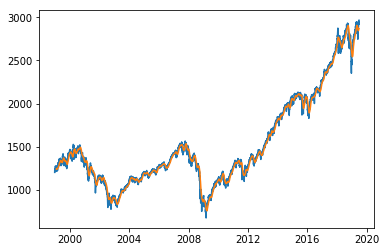

In [4]:
data=D_sp
roll_data=data.rolling(30).mean()
roll_data=roll_data.dropna()
plt.plot(D_sp)
plt.plot(roll_data)

### categorical label: 3 classes

In [5]:
def get_label(p_ini,data):
    label=0
    for k in range(len(data)):
        r=(float(data.iloc[k])-p_ini)/p_ini
        if r>0.025:
            label=0
            break
        elif r<-0.025:
            label=1
            break
        else:
            label=2
    return(label)

D=D_sp[:30]
p_ini=D.iloc[0]
data=D[1:]
get_label(p_ini,data) 


0

## preprocessing: 
### return datasets + associated labels

In [6]:

window=30
day_forcast=20
roll_window=5

def labelized(data_set):
    D=[]
    L=[]
    for k in range(0,len(data_set),roll_window):
        if k+window+day_forcast<len(data_set):
            df=data_set[k:k+window]
            p_ini=df.iloc[-1]
            data=data_set[k+window:k+window+day_forcast]
            label=get_label(p_ini,data)
            D.append(np.array(df))
            L.append(label)
        else:
            break

    D=pd.concat([pd.DataFrame(D[i]) for i in range(len(L))],axis=1)
    L=np.array(L)
    return(D,L)

def labelized_roll(data_set):
    roll_data=data_set.rolling(window).mean()
    data_set_new=data_set[window-1:]
    D=[]
    L=[]
    for k in range(0,len(data_set_new),roll_window):
        if k+window+day_forcast<len(data_set):
            df=data_set[k:k+window]
            roll_data_df=roll_data[k:k+window]
            p_ini=roll_data_df.iloc[-1]
            data=data_set_new[k+window:k+window+day_forcast]
            label=get_label(p_ini,data)
            D.append(np.array(df))
            L.append(label)
        else:
            break

    D=pd.concat([pd.DataFrame(D[i]) for i in range(len(L))],axis=1)
    L=np.array(L)
    return(D,L)

D,L=labelized(D_sp)
D,L=labelized_roll(D_sp)

In [7]:
D.shape
L.shape

(1061,)

In [8]:
N_sample=D.shape[1]
front=int(0.8*N_sample)

D_n=np.array(D)
x_train=D_n[:,0:front]
x_test=D_n[:,front:D_n.shape[1]]

y_train=L[:front]
y_test=L[front:]


nb_classes =len(np.unique(y_test))



x_test.shape
x_train.shape

(30, 848)

#### one hot encoding 

In [9]:
Y_train = keras.utils.to_categorical(y_train, nb_classes) 
Y_test = keras.utils.to_categorical(y_test, nb_classes) 
Y_train.shape

(848, 3)

In [10]:
x_train=get_norm(x_train)
x_test=get_norm(x_test)
x_train.shape


(30, 848)

In [11]:
x_train=x_train.T
x_test=x_test.T
x_train.shape

(848, 30)

In [12]:
x_train.shape
x_test.shape

(213, 30)

## defining the classifier: MLP

In [13]:
batch_size=50
nb_epochs=500

x = keras.layers.Input((window,))
y= keras.layers.Dropout(0.1)(x) 
y = keras.layers.Dense(500, activation='relu')(y) 
y = keras.layers.Dropout(0.2)(y) 
y = keras.layers.Dense(500, activation='relu')(y) 
y = keras.layers.Dropout(0.2)(y) 
y = keras.layers.Dense(500, activation = 'relu')(y) 
y = keras.layers.Dropout(0.3)(y) 
out = keras.layers.Dense(nb_classes, activation='softmax')(y) 

model = keras.models.Model(inputs=x, outputs=out)
optimizer = keras.optimizers.Adadelta() 
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy']) 

hist = model.fit(x_train, Y_train, batch_size=batch_size, nb_epoch=nb_epochs, 
verbose=2, validation_data=(x_test, Y_test))


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Colocations handled automatically by placer.
Train on 848 samples, validate on 213 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
 - 1s - loss: 0.8191 - acc: 0.6108 - val_loss: 0.8447 - val_acc: 0.6150
Epoch 2/500
 - 0s - loss: 0.7845 - acc: 0.6415 - val_loss: 0.7883 - val_acc: 0.6103
Epoch 3/500
 - 0s - loss: 0.7611 - acc: 0.6557 - val_loss: 0.8100 - val_acc: 0.5915
Epoch 4/500
 - 0s - loss: 0.7497 - acc: 0.6568 - val_loss: 0.8451 - val_acc: 0.6150
Epoch 5/500
 - 0s - loss: 0.7526 - acc: 0.6439 - val_loss: 0.8114 - val_acc: 0.6103
Epoch 6/500
 - 0s - loss: 0.7377 - acc: 0.6439 - val_loss: 0.8646 - val_acc: 0.6103
Epoch 7/500
 - 0s - loss: 0.7450 - acc: 0.6710 - val_loss: 0.8333 - val_acc: 0.6103
Epoch 8/500
 - 0s - loss: 0.7275 - acc: 0.6651 - val_loss: 0.8125 - val_acc: 0.6150
Epoch 9/500
 - 0s - loss: 0.7111 - acc: 0.6722 

Epoch 86/500
 - 0s - loss: 0.2970 - acc: 0.8774 - val_loss: 1.3274 - val_acc: 0.6009
Epoch 87/500
 - 0s - loss: 0.2972 - acc: 0.8868 - val_loss: 1.2806 - val_acc: 0.5822
Epoch 88/500
 - 0s - loss: 0.2928 - acc: 0.8844 - val_loss: 1.3113 - val_acc: 0.6103
Epoch 89/500
 - 0s - loss: 0.3042 - acc: 0.8632 - val_loss: 1.2633 - val_acc: 0.6150
Epoch 90/500
 - 0s - loss: 0.2739 - acc: 0.8809 - val_loss: 1.3738 - val_acc: 0.5869
Epoch 91/500
 - 0s - loss: 0.2986 - acc: 0.8880 - val_loss: 1.3559 - val_acc: 0.6291
Epoch 92/500
 - 0s - loss: 0.3318 - acc: 0.8585 - val_loss: 1.3627 - val_acc: 0.5681
Epoch 93/500
 - 0s - loss: 0.2917 - acc: 0.8821 - val_loss: 1.4089 - val_acc: 0.5681
Epoch 94/500
 - 0s - loss: 0.3101 - acc: 0.8809 - val_loss: 1.3949 - val_acc: 0.5962
Epoch 95/500
 - 0s - loss: 0.2832 - acc: 0.8880 - val_loss: 1.4291 - val_acc: 0.6150
Epoch 96/500
 - 0s - loss: 0.2848 - acc: 0.8821 - val_loss: 1.3465 - val_acc: 0.6056
Epoch 97/500
 - 0s - loss: 0.2707 - acc: 0.8927 - val_loss: 1.405

Epoch 182/500
 - 0s - loss: 0.1834 - acc: 0.9281 - val_loss: 1.5545 - val_acc: 0.6244
Epoch 183/500
 - 0s - loss: 0.1837 - acc: 0.9363 - val_loss: 1.7699 - val_acc: 0.6056
Epoch 184/500
 - 0s - loss: 0.1792 - acc: 0.9399 - val_loss: 1.6692 - val_acc: 0.6197
Epoch 185/500
 - 0s - loss: 0.1558 - acc: 0.9446 - val_loss: 1.6549 - val_acc: 0.6103
Epoch 186/500
 - 0s - loss: 0.1896 - acc: 0.9269 - val_loss: 1.6209 - val_acc: 0.6385
Epoch 187/500
 - 0s - loss: 0.1709 - acc: 0.9281 - val_loss: 1.6404 - val_acc: 0.5915
Epoch 188/500
 - 0s - loss: 0.2156 - acc: 0.9057 - val_loss: 1.6976 - val_acc: 0.6291
Epoch 189/500
 - 0s - loss: 0.1749 - acc: 0.9363 - val_loss: 1.7620 - val_acc: 0.6291
Epoch 190/500
 - 0s - loss: 0.1917 - acc: 0.9210 - val_loss: 1.7382 - val_acc: 0.6197
Epoch 191/500
 - 0s - loss: 0.2409 - acc: 0.9092 - val_loss: 1.6790 - val_acc: 0.6056
Epoch 192/500
 - 0s - loss: 0.1695 - acc: 0.9304 - val_loss: 1.6206 - val_acc: 0.6150
Epoch 193/500
 - 0s - loss: 0.1685 - acc: 0.9351 - val

Epoch 278/500
 - 0s - loss: 0.1243 - acc: 0.9564 - val_loss: 1.7743 - val_acc: 0.5915
Epoch 279/500
 - 0s - loss: 0.1216 - acc: 0.9540 - val_loss: 1.8188 - val_acc: 0.6526
Epoch 280/500
 - 0s - loss: 0.1224 - acc: 0.9575 - val_loss: 1.8910 - val_acc: 0.6338
Epoch 281/500
 - 0s - loss: 0.1631 - acc: 0.9434 - val_loss: 1.9035 - val_acc: 0.6150
Epoch 282/500
 - 0s - loss: 0.1777 - acc: 0.9304 - val_loss: 1.8224 - val_acc: 0.6197
Epoch 283/500
 - 0s - loss: 0.1159 - acc: 0.9599 - val_loss: 1.8582 - val_acc: 0.6056
Epoch 284/500
 - 0s - loss: 0.1180 - acc: 0.9564 - val_loss: 2.0672 - val_acc: 0.6103
Epoch 285/500
 - 0s - loss: 0.1234 - acc: 0.9517 - val_loss: 1.9379 - val_acc: 0.5962
Epoch 286/500
 - 0s - loss: 0.1432 - acc: 0.9469 - val_loss: 1.9662 - val_acc: 0.6244
Epoch 287/500
 - 0s - loss: 0.1175 - acc: 0.9564 - val_loss: 2.0129 - val_acc: 0.6385
Epoch 288/500
 - 0s - loss: 0.1364 - acc: 0.9575 - val_loss: 1.8981 - val_acc: 0.6338
Epoch 289/500
 - 0s - loss: 0.1685 - acc: 0.9328 - val

Epoch 374/500
 - 0s - loss: 0.1250 - acc: 0.9493 - val_loss: 2.0607 - val_acc: 0.6103
Epoch 375/500
 - 0s - loss: 0.1361 - acc: 0.9575 - val_loss: 1.8823 - val_acc: 0.6385
Epoch 376/500
 - 0s - loss: 0.0979 - acc: 0.9611 - val_loss: 2.2146 - val_acc: 0.6479
Epoch 377/500
 - 0s - loss: 0.1425 - acc: 0.9575 - val_loss: 1.9548 - val_acc: 0.6244
Epoch 378/500
 - 0s - loss: 0.1066 - acc: 0.9611 - val_loss: 1.9753 - val_acc: 0.6150
Epoch 379/500
 - 0s - loss: 0.1492 - acc: 0.9517 - val_loss: 2.0317 - val_acc: 0.6338
Epoch 380/500
 - 0s - loss: 0.1132 - acc: 0.9634 - val_loss: 1.9436 - val_acc: 0.6291
Epoch 381/500
 - 0s - loss: 0.1139 - acc: 0.9599 - val_loss: 1.9539 - val_acc: 0.6197
Epoch 382/500
 - 0s - loss: 0.0978 - acc: 0.9587 - val_loss: 2.1497 - val_acc: 0.6244
Epoch 383/500
 - 0s - loss: 0.1446 - acc: 0.9434 - val_loss: 2.0445 - val_acc: 0.6385
Epoch 384/500
 - 0s - loss: 0.1277 - acc: 0.9540 - val_loss: 1.9633 - val_acc: 0.6103
Epoch 385/500
 - 0s - loss: 0.1015 - acc: 0.9587 - val

Epoch 470/500
 - 0s - loss: 0.0924 - acc: 0.9682 - val_loss: 1.9922 - val_acc: 0.6291
Epoch 471/500
 - 0s - loss: 0.0976 - acc: 0.9670 - val_loss: 1.9565 - val_acc: 0.6150
Epoch 472/500
 - 0s - loss: 0.1080 - acc: 0.9623 - val_loss: 1.9925 - val_acc: 0.6291
Epoch 473/500
 - 0s - loss: 0.1054 - acc: 0.9623 - val_loss: 1.9620 - val_acc: 0.5962
Epoch 474/500
 - 0s - loss: 0.0757 - acc: 0.9693 - val_loss: 2.0617 - val_acc: 0.6009
Epoch 475/500
 - 0s - loss: 0.1028 - acc: 0.9646 - val_loss: 2.1039 - val_acc: 0.6244
Epoch 476/500
 - 0s - loss: 0.1297 - acc: 0.9481 - val_loss: 1.8744 - val_acc: 0.6244
Epoch 477/500
 - 0s - loss: 0.1115 - acc: 0.9564 - val_loss: 1.9524 - val_acc: 0.6385
Epoch 478/500
 - 0s - loss: 0.0945 - acc: 0.9741 - val_loss: 1.8952 - val_acc: 0.6338
Epoch 479/500
 - 0s - loss: 0.0675 - acc: 0.9729 - val_loss: 2.2115 - val_acc: 0.6150
Epoch 480/500
 - 0s - loss: 0.1197 - acc: 0.9505 - val_loss: 2.1614 - val_acc: 0.6150
Epoch 481/500
 - 0s - loss: 0.1061 - acc: 0.9611 - val

## Results

In [14]:
log = pd.DataFrame(hist.history)

In [15]:
log.head()


,loss,acc,val_loss,val_acc
0,0.819064,0.610849,0.844750,0.615023
1,0.784490,0.641509,0.788274,0.610329
2,0.761140,0.655660,0.809963,0.591549
3,0.749657,0.656840,0.845085,0.615023
4,0.752607,0.643868,0.811374,0.610329


In [16]:
log.shape

(500, 4)

In [17]:
print(log.loc[log['loss'].idxmin]['loss'], log.loc[log['loss'].idxmin]['val_acc'])

0.06751321369061633 0.6150234937667847


In [18]:
E=pd.concat([log['loss'],log['val_loss']],axis=1)
E.columns=['train','test']
A=pd.concat([log['acc'],log['val_acc']],axis=1)
A.columns=E.columns


Text(0, 0.5, 'error')

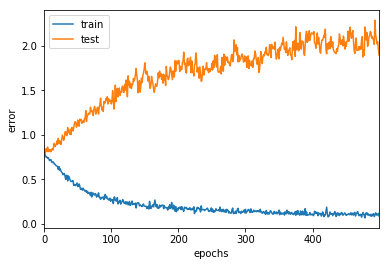

In [19]:
E.plot()
plt.xlabel('epochs')
plt.ylabel('error')
#plt.savefig('result_latex/error1')

Text(0, 0.5, 'accuracy')

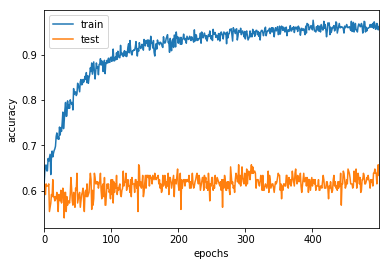

In [20]:
A.plot()
plt.xlabel('epochs')
plt.ylabel('accuracy')
#plt.savefig('result_latex/acc_1')

# Train on synthetic, test on real

### loading fake serie

In [21]:
ret_fake=pd.read_csv('fake.csv')
ret_fake_n=np.array(ret_fake)
ret_fake_n=ret_fake_n[:,1]

p_0=D_sp.iloc[0]
D_fake=p_0*cumreturn(ret_fake_n)
D_fake.shape

(5354,)

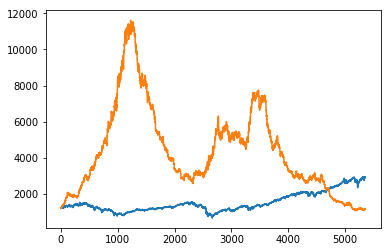

In [22]:
D_sp_t=np.array(D_sp[:len(D_sp)-1])
plt.plot(D_sp_t)
plt.plot(D_fake)

In [23]:
D_fake_df=pd.Series(D_fake)
D_fake_df.index=D_sp[:len(D_sp)-1].index
D_s,L_s=labelized_roll(D_fake_df)

D_fake_n=np.array(D_s)

x_train_s=D_fake_n

y_train_s=L_s
Y_train_s = keras.utils.to_categorical(y_train_s, nb_classes) 


## Train on synthetic

In [24]:
x_train_s=get_norm(x_train_s)
x_train_s=x_train_s.T


In [25]:
x_train_s.shape

(1061, 30)

In [26]:
hist_s = model.fit(x_train_s, Y_train_s, batch_size=batch_size, nb_epoch=nb_epochs, 
verbose=2, validation_data=(x_test, Y_test))

Train on 1061 samples, validate on 213 samples
Epoch 1/500
 - 0s - loss: 1.3942 - acc: 0.5938 - val_loss: 1.1058 - val_acc: 0.5869
Epoch 2/500
 - 0s - loss: 0.7849 - acc: 0.6805 - val_loss: 0.9890 - val_acc: 0.6009
Epoch 3/500
 - 0s - loss: 0.6938 - acc: 0.7012 - val_loss: 0.9620 - val_acc: 0.5915
Epoch 4/500
 - 0s - loss: 0.6582 - acc: 0.7078 - val_loss: 0.9595 - val_acc: 0.5915
Epoch 5/500
 - 0s - loss: 0.6034 - acc: 0.7352 - val_loss: 0.9125 - val_acc: 0.6009
Epoch 6/500
 - 0s - loss: 0.5774 - acc: 0.7257 - val_loss: 0.9527 - val_acc: 0.6197
Epoch 7/500
 - 0s - loss: 0.5703 - acc: 0.7333 - val_loss: 0.9593 - val_acc: 0.6150
Epoch 8/500
 - 0s - loss: 0.5395 - acc: 0.7531 - val_loss: 1.0242 - val_acc: 0.6244
Epoch 9/500
 - 0s - loss: 0.5480 - acc: 0.7380 - val_loss: 0.9473 - val_acc: 0.6150
Epoch 10/500
 - 0s - loss: 0.5380 - acc: 0.7606 - val_loss: 0.9391 - val_acc: 0.6150
Epoch 11/500
 - 0s - loss: 0.5331 - acc: 0.7615 - val_loss: 0.9507 - val_acc: 0.6056
Epoch 12/500
 - 0s - loss: 

Epoch 96/500
 - 0s - loss: 0.2517 - acc: 0.8944 - val_loss: 1.4884 - val_acc: 0.5446
Epoch 97/500
 - 0s - loss: 0.2225 - acc: 0.9133 - val_loss: 1.5580 - val_acc: 0.5164
Epoch 98/500
 - 0s - loss: 0.1982 - acc: 0.9208 - val_loss: 1.7640 - val_acc: 0.5587
Epoch 99/500
 - 0s - loss: 0.2160 - acc: 0.9114 - val_loss: 1.8464 - val_acc: 0.5117
Epoch 100/500
 - 0s - loss: 0.2078 - acc: 0.9171 - val_loss: 1.7096 - val_acc: 0.5587
Epoch 101/500
 - 0s - loss: 0.2056 - acc: 0.9171 - val_loss: 1.8081 - val_acc: 0.5352
Epoch 102/500
 - 0s - loss: 0.2001 - acc: 0.9208 - val_loss: 1.7520 - val_acc: 0.5305
Epoch 103/500
 - 0s - loss: 0.2069 - acc: 0.9105 - val_loss: 1.6924 - val_acc: 0.5681
Epoch 104/500
 - 0s - loss: 0.2602 - acc: 0.8944 - val_loss: 1.5610 - val_acc: 0.5211
Epoch 105/500
 - 0s - loss: 0.1987 - acc: 0.9161 - val_loss: 1.7181 - val_acc: 0.5399
Epoch 106/500
 - 0s - loss: 0.1957 - acc: 0.9274 - val_loss: 1.7874 - val_acc: 0.5352
Epoch 107/500
 - 0s - loss: 0.2405 - acc: 0.9001 - val_los

Epoch 192/500
 - 0s - loss: 0.1969 - acc: 0.9331 - val_loss: 1.9139 - val_acc: 0.5258
Epoch 193/500
 - 0s - loss: 0.1561 - acc: 0.9350 - val_loss: 1.9470 - val_acc: 0.5023
Epoch 194/500
 - 0s - loss: 0.1621 - acc: 0.9453 - val_loss: 2.0429 - val_acc: 0.5540
Epoch 195/500
 - 0s - loss: 0.1563 - acc: 0.9416 - val_loss: 1.9492 - val_acc: 0.5446
Epoch 196/500
 - 0s - loss: 0.1553 - acc: 0.9416 - val_loss: 2.1391 - val_acc: 0.5587
Epoch 197/500
 - 0s - loss: 0.1554 - acc: 0.9416 - val_loss: 2.0436 - val_acc: 0.5399
Epoch 198/500
 - 0s - loss: 0.1648 - acc: 0.9350 - val_loss: 2.0979 - val_acc: 0.5258
Epoch 199/500
 - 0s - loss: 0.1682 - acc: 0.9416 - val_loss: 2.1425 - val_acc: 0.5258
Epoch 200/500
 - 0s - loss: 0.1544 - acc: 0.9406 - val_loss: 2.0641 - val_acc: 0.5305
Epoch 201/500
 - 0s - loss: 0.1533 - acc: 0.9434 - val_loss: 2.1327 - val_acc: 0.5352
Epoch 202/500
 - 0s - loss: 0.1530 - acc: 0.9359 - val_loss: 2.0683 - val_acc: 0.5446
Epoch 203/500
 - 0s - loss: 0.1553 - acc: 0.9312 - val

Epoch 288/500
 - 0s - loss: 0.1382 - acc: 0.9557 - val_loss: 2.2258 - val_acc: 0.5587
Epoch 289/500
 - 0s - loss: 0.1375 - acc: 0.9463 - val_loss: 2.1883 - val_acc: 0.5446
Epoch 290/500
 - 0s - loss: 0.1408 - acc: 0.9463 - val_loss: 2.0836 - val_acc: 0.5352
Epoch 291/500
 - 0s - loss: 0.1114 - acc: 0.9642 - val_loss: 2.2360 - val_acc: 0.5587
Epoch 292/500
 - 0s - loss: 0.1430 - acc: 0.9519 - val_loss: 2.1748 - val_acc: 0.5399
Epoch 293/500
 - 0s - loss: 0.1440 - acc: 0.9519 - val_loss: 2.1002 - val_acc: 0.5399
Epoch 294/500
 - 0s - loss: 0.1099 - acc: 0.9614 - val_loss: 2.2542 - val_acc: 0.5399
Epoch 295/500
 - 0s - loss: 0.1551 - acc: 0.9472 - val_loss: 2.1004 - val_acc: 0.5352
Epoch 296/500
 - 0s - loss: 0.1405 - acc: 0.9510 - val_loss: 2.1203 - val_acc: 0.5540
Epoch 297/500
 - 0s - loss: 0.1277 - acc: 0.9463 - val_loss: 2.2451 - val_acc: 0.5493
Epoch 298/500
 - 0s - loss: 0.1473 - acc: 0.9425 - val_loss: 2.0343 - val_acc: 0.5164
Epoch 299/500
 - 0s - loss: 0.1128 - acc: 0.9585 - val

Epoch 384/500
 - 0s - loss: 0.1121 - acc: 0.9661 - val_loss: 2.3030 - val_acc: 0.5305
Epoch 385/500
 - 0s - loss: 0.1253 - acc: 0.9585 - val_loss: 2.3781 - val_acc: 0.5164
Epoch 386/500
 - 0s - loss: 0.1319 - acc: 0.9491 - val_loss: 2.2278 - val_acc: 0.5446
Epoch 387/500
 - 0s - loss: 0.1358 - acc: 0.9500 - val_loss: 2.1791 - val_acc: 0.5352
Epoch 388/500
 - 0s - loss: 0.1132 - acc: 0.9548 - val_loss: 2.2327 - val_acc: 0.5305
Epoch 389/500
 - 0s - loss: 0.1144 - acc: 0.9548 - val_loss: 2.2190 - val_acc: 0.5493
Epoch 390/500
 - 0s - loss: 0.1613 - acc: 0.9434 - val_loss: 2.0923 - val_acc: 0.5258
Epoch 391/500
 - 0s - loss: 0.1436 - acc: 0.9529 - val_loss: 2.0954 - val_acc: 0.5070
Epoch 392/500
 - 0s - loss: 0.1123 - acc: 0.9651 - val_loss: 2.2461 - val_acc: 0.5352
Epoch 393/500
 - 0s - loss: 0.1440 - acc: 0.9472 - val_loss: 2.2141 - val_acc: 0.5070
Epoch 394/500
 - 0s - loss: 0.1199 - acc: 0.9519 - val_loss: 2.2970 - val_acc: 0.5446
Epoch 395/500
 - 0s - loss: 0.0990 - acc: 0.9623 - val

Epoch 480/500
 - 0s - loss: 0.1176 - acc: 0.9538 - val_loss: 2.3702 - val_acc: 0.4930
Epoch 481/500
 - 0s - loss: 0.1046 - acc: 0.9614 - val_loss: 2.2238 - val_acc: 0.5211
Epoch 482/500
 - 0s - loss: 0.1128 - acc: 0.9548 - val_loss: 2.2271 - val_acc: 0.5540
Epoch 483/500
 - 0s - loss: 0.0927 - acc: 0.9614 - val_loss: 2.3010 - val_acc: 0.5493
Epoch 484/500
 - 0s - loss: 0.0758 - acc: 0.9727 - val_loss: 2.6617 - val_acc: 0.5211
Epoch 485/500
 - 0s - loss: 0.1446 - acc: 0.9538 - val_loss: 2.3759 - val_acc: 0.5164
Epoch 486/500
 - 0s - loss: 0.1178 - acc: 0.9538 - val_loss: 2.2491 - val_acc: 0.5211
Epoch 487/500
 - 0s - loss: 0.1277 - acc: 0.9463 - val_loss: 2.3784 - val_acc: 0.5446
Epoch 488/500
 - 0s - loss: 0.1284 - acc: 0.9491 - val_loss: 2.4671 - val_acc: 0.5446
Epoch 489/500
 - 0s - loss: 0.1327 - acc: 0.9529 - val_loss: 2.1457 - val_acc: 0.5352
Epoch 490/500
 - 0s - loss: 0.1075 - acc: 0.9548 - val_loss: 2.2465 - val_acc: 0.5399
Epoch 491/500
 - 0s - loss: 0.1123 - acc: 0.9566 - val

## Results

In [27]:
log_s = pd.DataFrame(hist_s.history)

E=pd.concat([log_s['loss'],log_s['val_loss']],axis=1)
E.columns=['train','test']
A=pd.concat([log_s['acc'],log_s['val_acc']],axis=1)
A.columns=E.columns



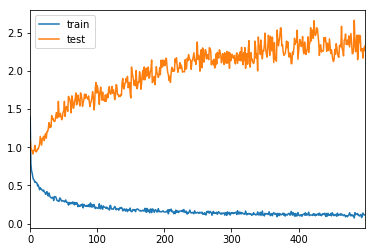

In [28]:
E.plot()

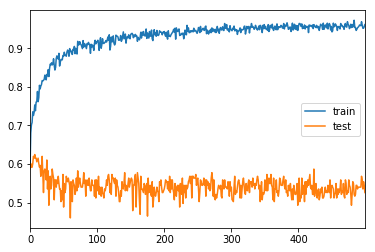

In [29]:
A.plot()

## using 30 fake series for the training

In [30]:
ret_fake=pd.read_csv('fake30_spx.csv')
ret_fake_n=np.array(ret_fake)
ret_fake_n=ret_fake_n[:,1:31]
ret_fake_n=pd.DataFrame(ret_fake_n)

p_0=D_sp.iloc[0]
#D_fake=p_0*cumreturn(ret_fake_n)
#D_fake=p_0*ret_fake_n
#D_fake.shape

In [31]:
D_fake=ret_fake_n
D_true=cumreturn(get_return(D_sp))

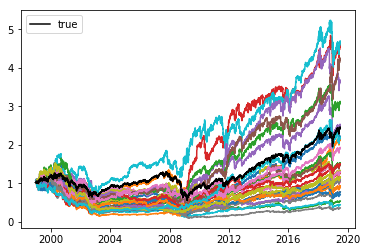

In [32]:
D_fake.index=D_true.index
plt.plot(D_fake)
plt.plot(D_true,color='black',label='true')
plt.legend()
#plt.savefig('result_latex/30samples.pdf')


In [33]:
D_fake.columns=[str(k) for k in range(30)]
L_D_s=[]
L=[]
for k in range(30):
    serie=D_fake[str(k)]
    D_s,L_s=labelized_roll(serie)
    L_D_s.append(D_s)
    L.append(L_s)
    
    

In [34]:
front=848
for k in range(len(L_D_s)):
    D_n=L_D_s[k]
    D_n=np.array(D)
    x_train=D_n[:,0:front]
    L_D_s[k]=x_train

#1 version  among the 30: as in the first case
L_D_s[1].shape

(30, 848)

In [35]:
#flatten label vector
L_a=np.array(L)
L_a_n=L_a[:,0:front]
L_a_flatt=L_a_n.flatten()
L_a_flatt.shape

(25440,)

In [36]:
#flatten return vector
D_final=np.zeros((30,front*30))
D_final=pd.concat([pd.DataFrame(L_D_s[k]) for k in range(len(L_D_s))],axis=1)
D_final.shape

(30, 25440)

In [37]:
D_fake_n=np.array(D_final)

x_train_s=D_fake_n

y_train_s=L_a_flatt
Y_train_s = keras.utils.to_categorical(y_train_s, nb_classes) 
Y_train_s.shape

(25440, 3)

In [38]:
x_train_s=get_norm(x_train_s)
x_train_s=x_train_s.T
x_train_s.shape

(25440, 30)

In [39]:
hist_s = model.fit(x_train_s, Y_train_s, batch_size=batch_size, nb_epoch=nb_epochs, 
verbose=2, validation_data=(x_test, Y_test))

Train on 25440 samples, validate on 213 samples
Epoch 1/500
 - 3s - loss: 0.7593 - acc: 0.6790 - val_loss: 0.8653 - val_acc: 0.6432
Epoch 2/500
 - 3s - loss: 0.6334 - acc: 0.7313 - val_loss: 0.8332 - val_acc: 0.6432
Epoch 3/500
 - 3s - loss: 0.5941 - acc: 0.7558 - val_loss: 0.8785 - val_acc: 0.6338
Epoch 4/500
 - 3s - loss: 0.5781 - acc: 0.7614 - val_loss: 0.8751 - val_acc: 0.6197
Epoch 5/500
 - 3s - loss: 0.5648 - acc: 0.7703 - val_loss: 0.8662 - val_acc: 0.6291
Epoch 6/500
 - 3s - loss: 0.5575 - acc: 0.7741 - val_loss: 0.9225 - val_acc: 0.6761
Epoch 7/500
 - 3s - loss: 0.5503 - acc: 0.7780 - val_loss: 0.9202 - val_acc: 0.6103
Epoch 8/500
 - 3s - loss: 0.5406 - acc: 0.7783 - val_loss: 0.8866 - val_acc: 0.6338
Epoch 9/500
 - 3s - loss: 0.5381 - acc: 0.7808 - val_loss: 0.8863 - val_acc: 0.6244
Epoch 10/500
 - 3s - loss: 0.5352 - acc: 0.7854 - val_loss: 0.8858 - val_acc: 0.6338
Epoch 11/500
 - 4s - loss: 0.5298 - acc: 0.7903 - val_loss: 0.8738 - val_acc: 0.6479
Epoch 12/500
 - 3s - loss:

Epoch 96/500
 - 3s - loss: 0.4846 - acc: 0.8092 - val_loss: 0.8884 - val_acc: 0.5962
Epoch 97/500
 - 3s - loss: 0.4824 - acc: 0.8077 - val_loss: 0.9421 - val_acc: 0.6103
Epoch 98/500
 - 3s - loss: 0.4829 - acc: 0.8081 - val_loss: 0.8908 - val_acc: 0.6338
Epoch 99/500
 - 3s - loss: 0.4851 - acc: 0.8069 - val_loss: 0.8945 - val_acc: 0.6244
Epoch 100/500
 - 3s - loss: 0.4831 - acc: 0.8091 - val_loss: 0.9060 - val_acc: 0.6291
Epoch 101/500
 - 3s - loss: 0.4807 - acc: 0.8094 - val_loss: 0.9299 - val_acc: 0.6150
Epoch 102/500
 - 3s - loss: 0.4859 - acc: 0.8086 - val_loss: 0.9101 - val_acc: 0.6244
Epoch 103/500
 - 3s - loss: 0.4821 - acc: 0.8107 - val_loss: 0.9127 - val_acc: 0.6291
Epoch 104/500
 - 3s - loss: 0.4806 - acc: 0.8109 - val_loss: 0.8967 - val_acc: 0.6244
Epoch 105/500
 - 3s - loss: 0.4864 - acc: 0.8071 - val_loss: 0.8989 - val_acc: 0.6291
Epoch 106/500
 - 3s - loss: 0.4822 - acc: 0.8086 - val_loss: 0.9147 - val_acc: 0.6244
Epoch 107/500
 - 3s - loss: 0.4836 - acc: 0.8092 - val_los

Epoch 192/500
 - 3s - loss: 0.4898 - acc: 0.8092 - val_loss: 0.9173 - val_acc: 0.6385
Epoch 193/500
 - 3s - loss: 0.4917 - acc: 0.8092 - val_loss: 0.9627 - val_acc: 0.6291
Epoch 194/500
 - 3s - loss: 0.4882 - acc: 0.8079 - val_loss: 0.9071 - val_acc: 0.6432
Epoch 195/500
 - 3s - loss: 0.4929 - acc: 0.8082 - val_loss: 0.9227 - val_acc: 0.6385
Epoch 196/500
 - 3s - loss: 0.4960 - acc: 0.8078 - val_loss: 0.9198 - val_acc: 0.6197
Epoch 197/500
 - 3s - loss: 0.4889 - acc: 0.8066 - val_loss: 0.9319 - val_acc: 0.6103
Epoch 198/500
 - 3s - loss: 0.4945 - acc: 0.8075 - val_loss: 0.9737 - val_acc: 0.6244
Epoch 199/500
 - 3s - loss: 0.4975 - acc: 0.8079 - val_loss: 0.9335 - val_acc: 0.6338
Epoch 200/500
 - 3s - loss: 0.4963 - acc: 0.8044 - val_loss: 0.9415 - val_acc: 0.6291
Epoch 201/500
 - 3s - loss: 0.4956 - acc: 0.8088 - val_loss: 0.9340 - val_acc: 0.6385
Epoch 202/500
 - 3s - loss: 0.4921 - acc: 0.8062 - val_loss: 0.9031 - val_acc: 0.6432
Epoch 203/500
 - 3s - loss: 0.4955 - acc: 0.8076 - val

Epoch 288/500
 - 4s - loss: 0.5005 - acc: 0.8053 - val_loss: 0.9189 - val_acc: 0.6526
Epoch 289/500
 - 3s - loss: 0.4985 - acc: 0.8088 - val_loss: 0.9083 - val_acc: 0.6338
Epoch 290/500
 - 4s - loss: 0.5018 - acc: 0.8042 - val_loss: 0.9249 - val_acc: 0.6291
Epoch 291/500
 - 4s - loss: 0.5021 - acc: 0.8047 - val_loss: 0.9238 - val_acc: 0.6338
Epoch 292/500
 - 4s - loss: 0.4982 - acc: 0.8051 - val_loss: 0.9354 - val_acc: 0.6479
Epoch 293/500
 - 3s - loss: 0.4985 - acc: 0.8098 - val_loss: 0.9291 - val_acc: 0.6291
Epoch 294/500
 - 3s - loss: 0.5015 - acc: 0.8053 - val_loss: 0.9372 - val_acc: 0.6150
Epoch 295/500
 - 3s - loss: 0.5001 - acc: 0.8061 - val_loss: 0.9298 - val_acc: 0.6432
Epoch 296/500
 - 3s - loss: 0.5062 - acc: 0.8040 - val_loss: 0.9131 - val_acc: 0.6338
Epoch 297/500
 - 4s - loss: 0.4993 - acc: 0.8050 - val_loss: 0.9402 - val_acc: 0.6432
Epoch 298/500
 - 3s - loss: 0.5020 - acc: 0.8049 - val_loss: 0.9328 - val_acc: 0.6009
Epoch 299/500
 - 4s - loss: 0.4948 - acc: 0.8065 - val

Epoch 384/500
 - 3s - loss: 0.5136 - acc: 0.8043 - val_loss: 0.9296 - val_acc: 0.6338
Epoch 385/500
 - 3s - loss: 0.5132 - acc: 0.8034 - val_loss: 0.9124 - val_acc: 0.6244
Epoch 386/500
 - 3s - loss: 0.5088 - acc: 0.8043 - val_loss: 0.8932 - val_acc: 0.6479
Epoch 387/500
 - 3s - loss: 0.5099 - acc: 0.8066 - val_loss: 0.8913 - val_acc: 0.6385
Epoch 388/500
 - 3s - loss: 0.5048 - acc: 0.8067 - val_loss: 0.9009 - val_acc: 0.6291
Epoch 389/500
 - 3s - loss: 0.5137 - acc: 0.8035 - val_loss: 0.9139 - val_acc: 0.6244
Epoch 390/500
 - 3s - loss: 0.5092 - acc: 0.8055 - val_loss: 0.9316 - val_acc: 0.6526
Epoch 391/500
 - 3s - loss: 0.5079 - acc: 0.8044 - val_loss: 0.9355 - val_acc: 0.6197
Epoch 392/500
 - 3s - loss: 0.5139 - acc: 0.8025 - val_loss: 0.8977 - val_acc: 0.6526
Epoch 393/500
 - 3s - loss: 0.5141 - acc: 0.8060 - val_loss: 0.9009 - val_acc: 0.6432
Epoch 394/500
 - 3s - loss: 0.5084 - acc: 0.8027 - val_loss: 0.8871 - val_acc: 0.6338
Epoch 395/500
 - 3s - loss: 0.5061 - acc: 0.8055 - val

Epoch 480/500
 - 3s - loss: 0.5164 - acc: 0.7982 - val_loss: 0.9433 - val_acc: 0.6244
Epoch 481/500
 - 4s - loss: 0.5182 - acc: 0.8011 - val_loss: 0.9499 - val_acc: 0.6432
Epoch 482/500
 - 4s - loss: 0.5228 - acc: 0.8013 - val_loss: 0.9117 - val_acc: 0.6291
Epoch 483/500
 - 3s - loss: 0.5165 - acc: 0.8002 - val_loss: 0.9244 - val_acc: 0.6338
Epoch 484/500
 - 3s - loss: 0.5229 - acc: 0.8022 - val_loss: 0.9536 - val_acc: 0.6479
Epoch 485/500
 - 4s - loss: 0.5172 - acc: 0.8027 - val_loss: 0.9154 - val_acc: 0.6338
Epoch 486/500
 - 4s - loss: 0.5245 - acc: 0.7994 - val_loss: 0.9603 - val_acc: 0.6244
Epoch 487/500
 - 4s - loss: 0.5210 - acc: 0.8026 - val_loss: 0.8950 - val_acc: 0.6291
Epoch 488/500
 - 3s - loss: 0.5222 - acc: 0.8006 - val_loss: 0.9162 - val_acc: 0.6432
Epoch 489/500
 - 4s - loss: 0.5173 - acc: 0.8011 - val_loss: 0.9069 - val_acc: 0.6385
Epoch 490/500
 - 4s - loss: 0.5214 - acc: 0.7997 - val_loss: 0.9144 - val_acc: 0.6479
Epoch 491/500
 - 4s - loss: 0.5270 - acc: 0.8001 - val

Text(0, 0.5, 'accuracy')

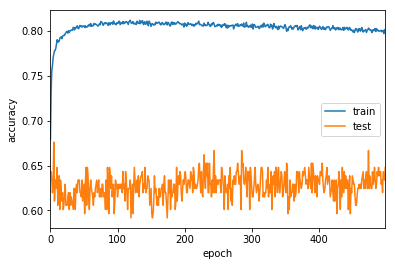

In [40]:
log = pd.DataFrame(hist_s.history)
E=pd.concat([log['loss'],log['val_loss']],axis=1)
E.columns=['train','test']
A=pd.concat([log['acc'],log['val_acc']],axis=1)
A.columns=E.columns
A.plot()
plt.xlabel('epoch')
plt.ylabel('accuracy')
#plt.savefig('result_latex/acc2')


Text(0, 0.5, 'error')

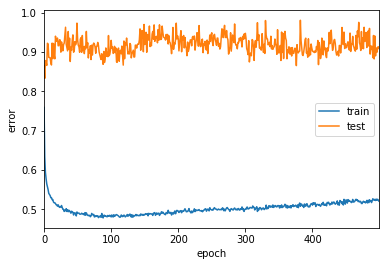

In [41]:
E.plot()
plt.xlabel('epoch')
plt.ylabel('error')
#plt.savefig('result_latex/error2')